In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np
pd.set_option('display.max_columns', 200)
import warnings
warnings.filterwarnings('ignore')
import re
import csv
import os
import re


In [2]:
# Name of the CSV file
file_name = 'revList.csv'

# List to store the DataFrames
found_files = []

# Open the CSV file for reading
with open(file_name, mode='r', newline='', encoding='utf-8') as file:
    # Create a CSV reader
    csv_reader = csv.reader(file, delimiter=';')
    
    # Skip the first line (header)
    next(csv_reader)
    
    # Read the remaining lines and process each line
    for row in csv_reader:
        project = row[0]
        merge_commit = row[1]
        class_name = row[2]
        method = row[3]
        # left_modification = row[4]
        # has_build = row[5]
        # left_deletion = row[6]
        # right_modification = row[7]
        # right_deletion = row[8]
        # realistic_case_path = row[9]

        # Generate path
        parts = class_name.split('.')
        class_name = parts.pop()
        class_path = '.'.join(parts).replace(".", "/")

        path_file = f"joana/reports/{project}/{merge_commit}/{class_path}/executionSummary.csv"
        
        if os.path.exists(path_file):
            df = pd.read_csv(path_file, sep=';')
            
            # Add context columns to the DataFrame
            df['project'] = project
            df['merge commit'] = merge_commit
            df['class'] = class_name
            df['original method'] = method
        else:

            data = {
                'project': project,
                'merge commit': merge_commit,
                'class': class_name,
                'original method': method,
                'SdgCreated': ['not found']
            }
            
            df = pd.DataFrame(data)

        # Reorder columns to have new columns at the beginning
        columns_order = ['project', 'merge commit', 'class', 'original method'] + [col for col in df.columns if col not in ['project', 'merge commit', 'class', 'original method']]
        df = df[columns_order]
        found_files.append(df)

    
    # Check if there are DataFrames to concatenate
    if len(found_files) > 0:
        found_files = [df.drop(columns=['Method']) for df in found_files]

        # Concatenate all DataFrames, keeping all rows and columns
        merged_file = pd.concat(found_files, ignore_index=True, sort=False)
        
        # Save the result to a new CSV file with ';' as separator
        merged_file.to_csv('merged_file.csv', index=False, sep=';')
        print("Files merged successfully! File saved as 'merged_file.csv'.")
    else:
        print("No file was found!")


Files merged successfully! File saved as 'merged_file.csv'.


Reading analyses execution results...
Generating results...
Results in results.pdf


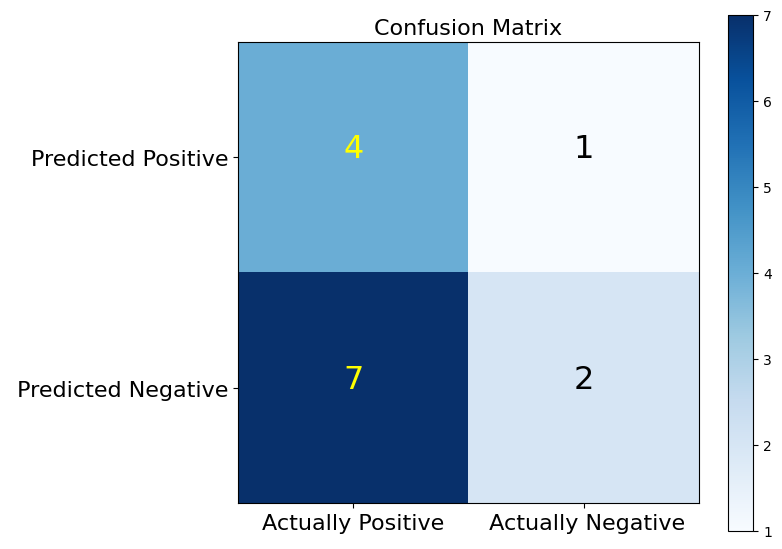

In [3]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter
from matplotlib import pyplot as plt
from fpdf import FPDF

class ReportAnalysis:

    def __init__(self, path_result, path_ground_truth):
        self.soot_results = pd.read_csv(path_result, sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)
        self.loi = pd.read_csv(path_ground_truth, sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)

        self.generate_results()

    def get_method_name(self, method_declaration):
        match = re.search(r'\.([a-zA-Z_][a-zA-Z0-9_]*)\(', method_declaration)
        if match:
            method_name = match.group(1)
            print("Method name:", method_name)
        else:
            print("Method name not found.")

    def get_loi(self, project, class_name,  method, merge_commit):
        df = pd.read_csv("LOI.csv", delimiter=';')
    
        # Encontrar o índice do ponto final e do parêntese
        dot_index = method.rfind('.')
        paren_index = method.find('(')

        method_name = ""

        # Extrair o nome do método
        if dot_index != -1 and paren_index != -1:
            method_name = method[dot_index + 1:paren_index]

        value_LOI = ("", "")
        
        for project_l, class_name_l, method_l, merge_commit_l, LOI, original_sample in zip(
            df['Project'], 
            df['Class Name'], 
            df['Method or field declaration changed by the two merged branches'], 
            df['Merge Commit'], 
            df['Locally Observable Interference'],
            df['Original Sample'],
        ):
            if (project_l == project and 
                class_name in class_name_l  and 
                method_name in method_l and 
                merge_commit_l == merge_commit):
                
                value_LOI = (LOI, original_sample)

                break  # Para parar no primeiro match encontrado

        return value_LOI

    def calculate_matrix_loi(self, columns):
        results = []
        loi_list = []
        original_sample_list = []
        info_LOI = ['project', 'class', 'original method', 'merge commit']
        
        # Limpar espaços em branco nos nomes das colunas
        self.soot_results.columns = self.soot_results.columns.str.strip()

        for index, row in self.soot_results.iterrows():
            value = row['HasSourcedAndSink']
                    
            values_LOI = [row[column] for column in info_LOI if column in row]

            (loi_actual, original_sample) = self.get_loi(*values_LOI)
            
            loi_list.append(loi_actual)
            original_sample_list.append(original_sample)

            result = "-"
            # Determinar o resultado
            if "Yes" in str(value) and "Yes" in loi_actual:
                result = "TRUE POSITIVE"
            elif "No" in str(value) and "No" in loi_actual:
                result = "TRUE NEGATIVE"
            elif "No" in str(value) and "Yes" in loi_actual:
                result = "FALSE NEGATIVE"
            elif "Yes" in str(value) and "No" in loi_actual:
                result = "FALSE POSITIVE"
            
            results.append(result)
            
        df = pd.read_csv('merged_file.csv', sep=';')
        df['LOI'] = loi_list
        df['Original Sample'] = original_sample_list
        df['result'] = results

        # Salvar o novo DataFrame em um novo arquivo CSV
        new_csv_path = 'results.csv'
        df.to_csv(new_csv_path, sep=';', index=False)

        return results

    def generate_results(self):

        print("Generating results...")

        FP,TP, FN, TN = 0, 0, 0, 0

        list_columns = self.soot_results.columns.tolist()

        result_matrix = self.calculate_matrix_loi(list_columns)

        for elem, count in Counter(result_matrix).items():
            if (elem == 'FALSE POSITIVE'):
                FP = count
            if (elem == 'FALSE NEGATIVE'):
                FN = count
            if (elem == 'TRUE POSITIVE'):
                TP = count
            if (elem == 'TRUE NEGATIVE'):
                TN = count

        sensitivity = 0 if ((TP + FN) == 0) else (TP / (TP + FN))
        precision = 0 if ((TP + FP) == 0) else (TP / (TP + FP))
        f1_score = 0 if ((2*TP + FP + FN) == 0) else (2*TP / (2*TP + FP + FN))
        accuracy = 0 if ((FP + TP + TN + FN) == 0) else ((TP + TN) / (FP + TP + TN + FN))

        df = pd.read_csv("results.csv", sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)
       
        fail_results = df['result'].eq("-").sum()
        total = len(df)

        # variable pdf
        pdf = FPDF()

        # add a page
        pdf.add_page()

        # set style and size of font
        # that you want in the pdf
        pdf.set_font("Arial", size = 15)

        # create a cell
        pdf.cell(200, 10, txt = "Results for execution",
                 ln = 1, align = 'C')
    
        pdf.cell(200, 10, txt = ("Precision: "+str(round(precision, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("Recall: "+str(round(sensitivity, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("F1 Score: "+str(round(f1_score, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("Accuracy: "+str(round(accuracy, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("False Positives: "+str(FP)),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("False Negatives: "+str(FN)),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("True Positives: "+str(TP)),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("True Negatives: "+str(TN)),
                 ln = 2, align = 'L')
        
        pdf.cell(200, 10, txt = (f"Total produzed: {total-fail_results} out of {total} units"),
                 ln = 2, align = 'L')

        cm = np.array([[TP,  FP], [FN, TN]])
        normalize = False
        target_names = ['Actually Positive', ' Actually Negative']
        target_names2 = ['Predicted Positive', ' Predicted Negative']
        title = "Confusion Matrix"

        cmap = plt.get_cmap('Blues')

        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title, fontsize=16)
        plt.colorbar()

        if target_names is not None:
            tick_marks = np.arange(len(target_names))
            plt.xticks(tick_marks, target_names, fontsize=16)
            plt.yticks(tick_marks, target_names2, fontsize=16)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 1.5 if normalize else cm.max() / 2
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="yellow" if cm[i, j] > thresh else "black", fontsize=23)
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="yellow" if cm[i, j] > thresh else "black", fontsize=23)
        plt.tight_layout()

        plt.savefig("confusion_matrix.jpg")

        pdf.image("confusion_matrix.jpg", x = None, y = None, w = 160, h = 110, type = 'jpg', link = 'confusion_matrix.jpg')

        # Save the pdf with name .pdf
        pdf.output("results.pdf")
        # pdf.output("results.pdf")

        print("Results in results.pdf")

path_ground_truth = "LOI.csv"
path_result = 'merged_file.csv'

print("Reading analyses execution results...")

ReportAnalysis(path_result, path_ground_truth)



In [4]:

path_result = 'merged_file.csv'

print("Reading analyses execution results...")
soot_results = pd.read_csv(path_result, sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)

soot_results.columns = soot_results.columns.str.strip()
list_time_seconds = []

for index, row in soot_results.iterrows():
    value = row['Time (ms)']
    try:
        # Ignora valores que não são numéricos, como ' -'
        if str(value) not in ['', '-', 'NaN', 'nan']:
            list_time_seconds.append(float(value) / 1000)
    except ValueError:
        continue
       
print(list_time_seconds)


Reading analyses execution results...
[14840.929, 79.359, 27731.963, 27731.963, 27731.963, 93.328, 98.003, 98.003, 89.479, 11735.528, 16357.635, 164.587, 3200.744, 3200.744]


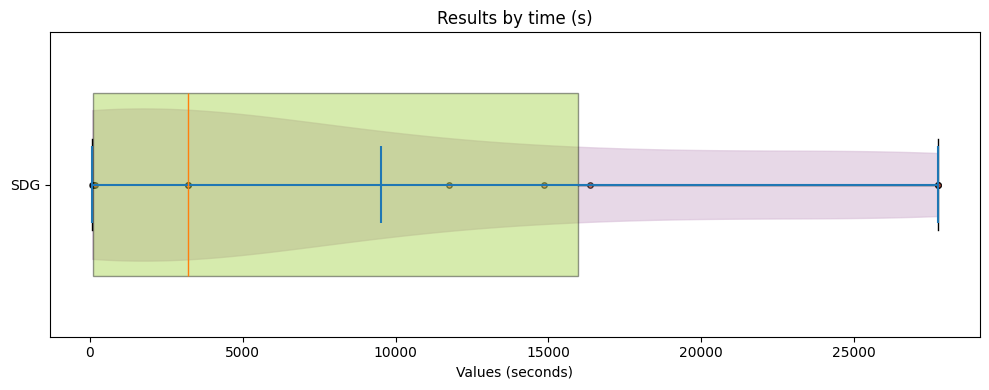

In [5]:
import random

# Exemplo de classe que utiliza a função plot_by_variable
class Plotter:
    def __init__(self):
        pass

    def plot_by_variable(self, leg1, leg_x, time_list1):
        # Define o tamanho da figura
        fig, ax = plt.subplots(figsize=(10, 4))

        # Dados
        data_x = [time_list1]

        # Cores para os gráficos
        boxplot_color = 'yellowgreen'
        violin_color = 'thistle'
        scatter_color = 'tomato'

        # Boxplot
        bp = ax.boxplot(data_x, patch_artist=True, vert=False, positions=[1], widths=0.6)
        for patch in bp['boxes']:
            patch.set_facecolor(boxplot_color)
            patch.set_alpha(0.4)

        # Violinplot
        vp = ax.violinplot(data_x, points=500, showmeans=True, showextrema=True, showmedians=False, vert=False)
        for b in vp['bodies']:
            b.set_color(violin_color)
            b.set_alpha(0.6)

        # Scatterplot
        features = data_x[0]
        y = np.full(len(features), 1)  # Usando apenas 1 para a posição no eixo Y
        jitter = np.random.uniform(low=-0.1, high=0.1, size=len(features))
        ax.scatter(features + jitter, y, s=15, c=scatter_color, alpha=0.7, edgecolor='k')

        # Configurações do gráfico
        ax.set_yticks([1])
        ax.grid(False)
        ax.set_yticklabels([leg1])
        ax.set_xlabel(leg_x)
        ax.set_title("Results by time (s)")
        plt.tight_layout()
        plt.savefig("rain_cloud_time_sdg.jpg", dpi=300)
        plt.show()

    
# Criar uma instância da classe ExamplePlotter
plotter = Plotter()

# Nome da variável a ser plotada
y = "SDG"
x = "Values (seconds)"

# Chamar a função para plotar o gráfico
plotter.plot_by_variable(y, x, list_time_seconds)

#time_list = [random.uniform(0.5, 3.5) for _ in range(100)]
#plotter.plot_by_variable(y, x, time_list)


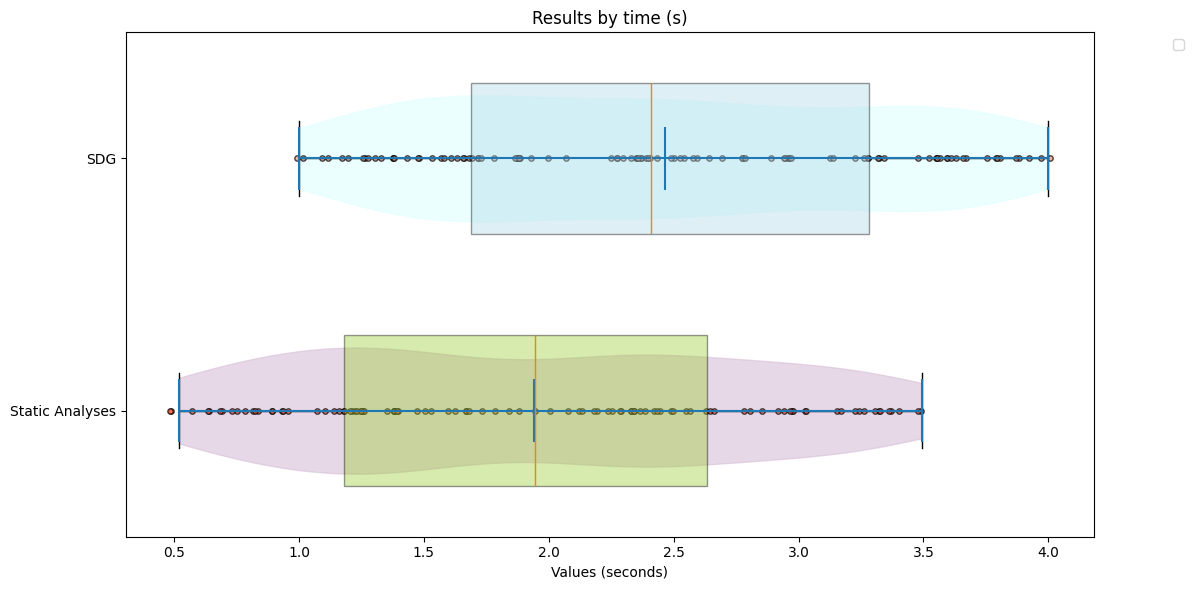

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Exemplo de classe que utiliza a função plot_by_variable
class Plotter:
    def __init__(self):
        pass

    def plot_by_variable(self, leg1, leg2, leg_x, time_list1, time_list2):
        # Define o tamanho da figura
        fig, ax = plt.subplots(figsize=(12, 6))

        # Dados
        data_x = [time_list1, time_list2]

        # Cores para os gráficos
        boxplots_colors = ['yellowgreen', 'lightblue']
        violin_colors = ['thistle', 'lightcyan']
        scatter_colors = ['tomato', 'darksalmon']

        # Boxplot
        bp = ax.boxplot(data_x, patch_artist=True, vert=False, positions=[1, 2], widths=0.6)
        for patch, color in zip(bp['boxes'], boxplots_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.4)

        # Violinplot
        vp = ax.violinplot(data_x, points=500, showmeans=True, showextrema=True, showmedians=False, vert=False)
        for idx, b in enumerate(vp['bodies']):
            b.set_color(violin_colors[idx])
            b.set_alpha(0.6)

        # Scatterplot
        for idx, features in enumerate(data_x):
            y = np.full(len(features), idx + 1)
            jitter = np.random.uniform(low=-0.1, high=0.1, size=len(features))
            ax.scatter(features + jitter, y, s=15, c=scatter_colors[idx], alpha=0.7, edgecolor='k')

        # Configurações do gráfico
        ax.set_yticks([1, 2])
        ax.grid(False)
        ax.set_yticklabels([leg1, leg2])
        ax.set_xlabel(leg_x)
        ax.set_title("Results by time (s)")
        ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
        plt.tight_layout()
        plt.savefig("rain_cloud_time_sdg_sam.jpg", dpi=300)
        plt.show()

       
# Criar uma instância da classe Plotter
plotter = Plotter()

# Gerar duas listas de tempos de exemplo (em segundos)
random.seed(42)  # Para reprodutibilidade
time_list1 = [random.uniform(0.5, 3.5) for _ in range(100)]
time_list2 = [random.uniform(1.0, 4.0) for _ in range(100)]

# Nome da variável a ser plotada
variable = "Execution Time"

# Chamar a função para plotar o gráfico
plotter.plot_by_variable("Static Analyses", "SDG", "Values (seconds)", time_list1, time_list2)
